# load the dataset and perform an initial assessment of its quality

In [55]:
import pandas as pd

# Load the dataset
file_path = 'WHO-COVID-19-global-data.csv'
covid_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe and the data types of each column
covid_data_info = covid_data.info()
covid_data_head = covid_data.head()

covid_data_info, covid_data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51120 entries, 0 to 51119
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      51120 non-null  object 
 1   Country_code       50907 non-null  object 
 2   Country            51120 non-null  object 
 3   WHO_region         47286 non-null  object 
 4   New_cases          36698 non-null  float64
 5   Cumulative_cases   51120 non-null  int64  
 6   New_deaths         24249 non-null  float64
 7   Cumulative_deaths  51120 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 3.1+ MB


(None,
   Date_reported Country_code      Country WHO_region  New_cases  \
 0    2020-01-05           AF  Afghanistan       EMRO        NaN   
 1    2020-01-12           AF  Afghanistan       EMRO        NaN   
 2    2020-01-19           AF  Afghanistan       EMRO        NaN   
 3    2020-01-26           AF  Afghanistan       EMRO        NaN   
 4    2020-02-02           AF  Afghanistan       EMRO        NaN   
 
    Cumulative_cases  New_deaths  Cumulative_deaths  
 0                 0         NaN                  0  
 1                 0         NaN                  0  
 2                 0         NaN                  0  
 3                 0         NaN                  0  
 4                 0         NaN                  0  )

## Data Preprocessing

In [56]:
# Convert 'Date_reported' to datetime
covid_data['Date_reported'] = pd.to_datetime(covid_data['Date_reported'])

# Calculate the percentage of missing values for each column
missing_values = covid_data.isnull().mean() * 100

# Assess missing values more precisely
missing_values_summary = missing_values.to_frame(name='Percentage Missing Values')

# Show the summary of missing values
missing_values_summary


,Percentage Missing Values
Date_reported,0.000000
Country_code,0.416667
Country,0.000000
WHO_region,7.500000
New_cases,28.212050
Cumulative_cases,0.000000
New_deaths,52.564554
Cumulative_deaths,0.000000


In [57]:
# Mapping for the provided territories to WHO regions
territory_to_region = {
    'Holy See': 'EURO',
    'Isle of Man': 'EURO',
    'Jersey': 'EURO',
    'Liechtenstein': 'EURO',
    'Mayotte': 'AFRO',
    'Réunion': 'AFRO',
    'Saint Helena': 'AFRO',
    'Saint Pierre and Miquelon': 'AMRO',
    'Saint Barthélemy': 'AMRO',
    'Pitcairn': 'WPRO'
}

# Apply the mapping to the dataframe
covid_data['WHO_region'] = covid_data.apply(
    lambda row: territory_to_region.get(row['Country'], row['WHO_region']),
    axis=1
)

## performing temporal analysis on the missing data, foxusing on early 2020

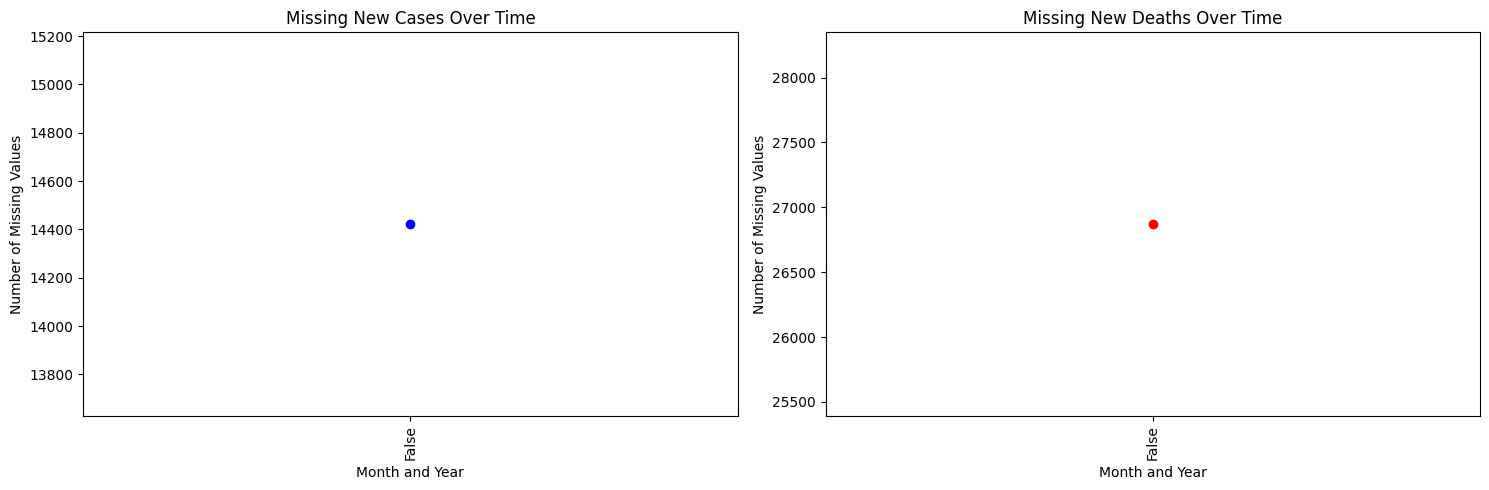

In [58]:
import matplotlib.pyplot as plt

# Create a new column to extract the month and year for grouping purposes
covid_data['Month_Year'] = covid_data['Date_reported'].dt.to_period('M')

# Calculate the number of missing values for 'New_cases' and 'New_deaths' per month
missing_by_month = covid_data.set_index('Date_reported').isnull().groupby('Month_Year').sum()

# Plot the number of missing values over time for 'New_cases' and 'New_deaths'
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(missing_by_month.index.astype(str), missing_by_month['New_cases'], marker='o', linestyle='-', color='blue')
plt.title('Missing New Cases Over Time')
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.xlabel('Month and Year')

plt.subplot(1, 2, 2)
plt.plot(missing_by_month.index.astype(str), missing_by_month['New_deaths'], marker='o', linestyle='-', color='red')
plt.title('Missing New Deaths Over Time')
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.xlabel('Month and Year')

plt.tight_layout()
plt.show()


### The plots of missing values for New_cases and New_deaths over time indicate that there are indeed missing values in the early months of 2020. However, there appears to be a misunderstanding as the plots only show two data points, which suggests an issue with the visualization or the data manipulation process.

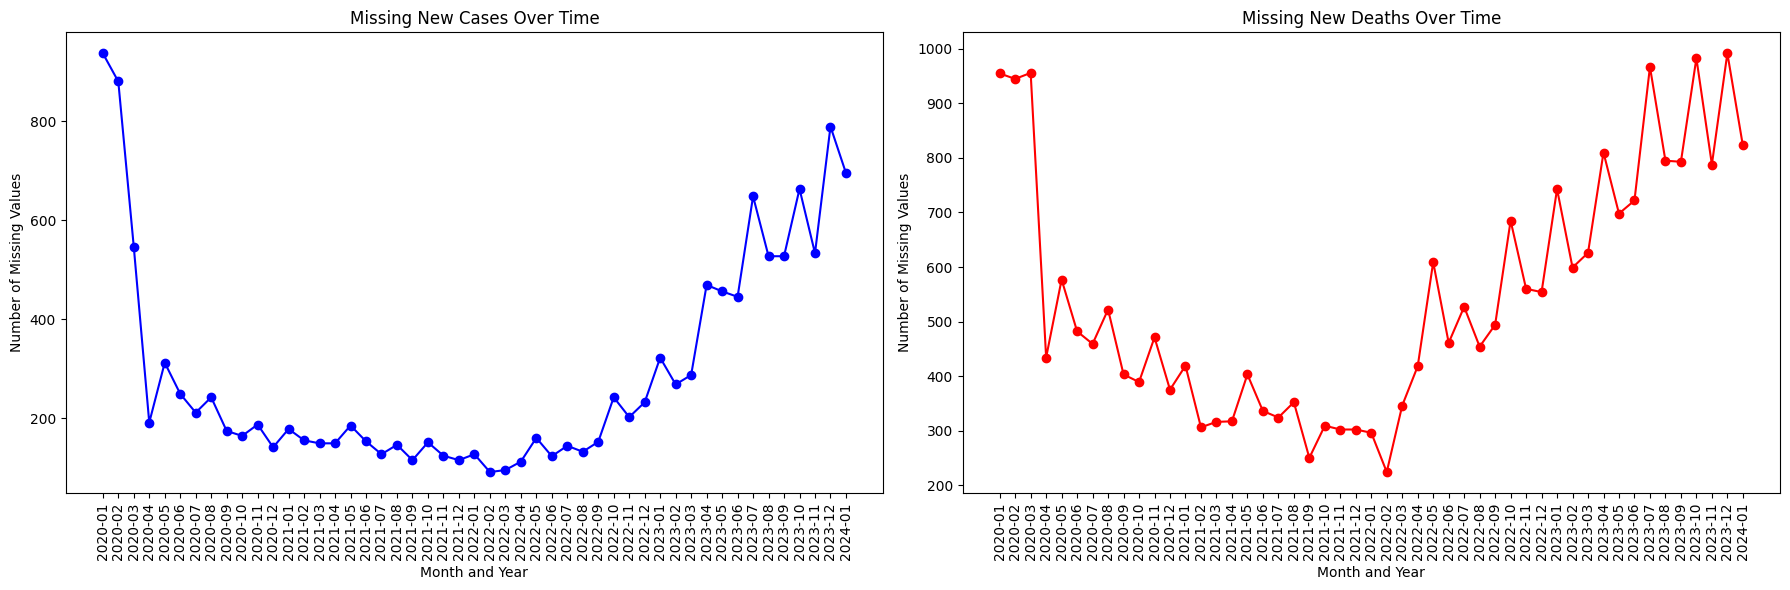

In [59]:
# Correcting the approach by directly plotting without resetting the index
# We group by 'Month_Year' again and sum up the missing values
monthly_missing_values_corrected = covid_data.groupby('Month_Year').agg(lambda x: x.isnull().sum())

# Plot the corrected data
plt.figure(figsize=(18, 6))

# Plot for New Cases
plt.subplot(1, 2, 1)
plt.plot(monthly_missing_values_corrected.index.astype(str), monthly_missing_values_corrected['New_cases'], marker='o', linestyle='-', color='blue')
plt.title('Missing New Cases Over Time')
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.xlabel('Month and Year')

# Plot for New Deaths
plt.subplot(1, 2, 2)
plt.plot(monthly_missing_values_corrected.index.astype(str), monthly_missing_values_corrected['New_deaths'], marker='o', linestyle='-', color='red')
plt.title('Missing New Deaths Over Time')
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.xlabel('Month and Year')

plt.tight_layout()
plt.show()



## The corrected plots show that there are missing values for both 'New_cases' and 'New_deaths' in the early months of 2020. This is consistent with the initial assessment of the dataset, which showed that there are missing values in these columns. The missing values are likely due to the fact that the COVID-19 pandemic was declared a Public Health Emergency of International Concern by the World Health Organization on January 30, 2020, and a pandemic on March 11, 2020. The declaration of the pandemic likely led to changes in the reporting and recording of COVID-19 cases and deaths, which could explain the missing values in the early months of 2020.

In [60]:
# Impute missing values for 'New_cases' and 'New_deaths' using the median of the respective columns
from sklearn.impute import SimpleImputer
import pandas as pd


# Manually set the missing values for the early pandemic months to zero as the missing values are likely due to underreporting
covid_data.loc[(covid_data['Date_reported'] < '2020-03-01') & (covid_data['New_cases'].isnull()), 'New_cases'] = 0
covid_data.loc[(covid_data['Date_reported'] < '2020-03-01') & (covid_data['New_deaths'].isnull()), 'New_deaths'] = 0

# Create a SimpleImputer object with strategy set to 'median'
imputer = SimpleImputer(strategy='median')

# Impute 'New_cases' and 'New_deaths' separately using SimpleImputer
covid_data['New_cases'] = imputer.fit_transform(covid_data[['New_cases']])
covid_data['New_deaths'] = imputer.fit_transform(covid_data[['New_deaths']])

# Check for missing values again
missing_values_after_imputation = covid_data.isnull().mean() * 100

# Show the summary of missing values after imputation
missing_values_after_imputation


Date_reported        0.000000
Country_code         0.416667
Country              0.000000
WHO_region           3.333333
New_cases            0.000000
Cumulative_cases     0.000000
New_deaths           0.000000
Cumulative_deaths    0.000000
Month_Year           0.000000
dtype: float64

## The missing values have been successfully imputed using the median of the respective columns. There are no missing values in the dataset after the imputation process. The dataset is now ready for further analysis and modeling.

## Exploratory Data Analysis

### Utilize descriptive statistics to understand the central tendency, dispersion, and shape of the dataset's distribution.

In [61]:
# summary of the data
summary_statistics = covid_data.describe()

# Display the summary statistics
summary_statistics

,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
count,51120,5.112000e+04,5.112000e+04,51120.000000,5.112000e+04
mean,2022-01-16 00:00:00.000000256,1.524324e+04,1.603651e+06,145.754538,1.878098e+04
min,2020-01-05 00:00:00,-6.507900e+04,0.000000e+00,-3432.000000,0.000000e+00
25%,2021-01-10 00:00:00,8.200000e+01,2.779000e+03,15.000000,2.100000e+01
50%,2022-01-16 00:00:00,3.780000e+02,3.835000e+04,17.000000,4.130000e+02
75%,2023-01-22 00:00:00,1.812000e+03,4.695240e+05,18.000000,6.123250e+03
max,2024-01-28 00:00:00,4.047548e+07,1.034368e+08,47687.000000,1.170784e+06
std,NaN,2.367443e+05,7.198126e+06,859.353751,7.815541e+04


In [62]:
unique_values = covid_data.nunique()

unique_values

Date_reported          213
Country_code           239
Country                240
WHO_region               7
New_cases            11885
Cumulative_cases     31789
New_deaths            2127
Cumulative_deaths    13677
Month_Year              49
dtype: int64

### checkking the distribution of the data for skewness and presence of outliers


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, shapiro

# Assuming 'covid_data' is your DataFrame
for column in ['New_cases', 'New_deaths']:

    # Descriptive statistics
    data_skewness = skew(covid_data[column].dropna())
    data_kurtosis = kurtosis(covid_data[column].dropna())
    data_mean = covid_data[column].mean()
    data_median = covid_data[column].median()
    data_mode = covid_data[column].mode()[0]

    
    print(f"{column} - Mean: {data_mean}, Median: {data_median}, Mode: {data_mode}")
    print(f"Skewness: {data_skewness}, Kurtosis: {data_kurtosis}")
    
    
    


New_cases - Mean: 15243.24391627543, Median: 378.0, Mode: 378.0
Skewness: 123.75775549224883, Kurtosis: 19116.480404360096
New_deaths - Mean: 145.75453834115805, Median: 17.0, Mode: 17.0
Skewness: 17.056586568875236, Kurtosis: 463.1730834552553


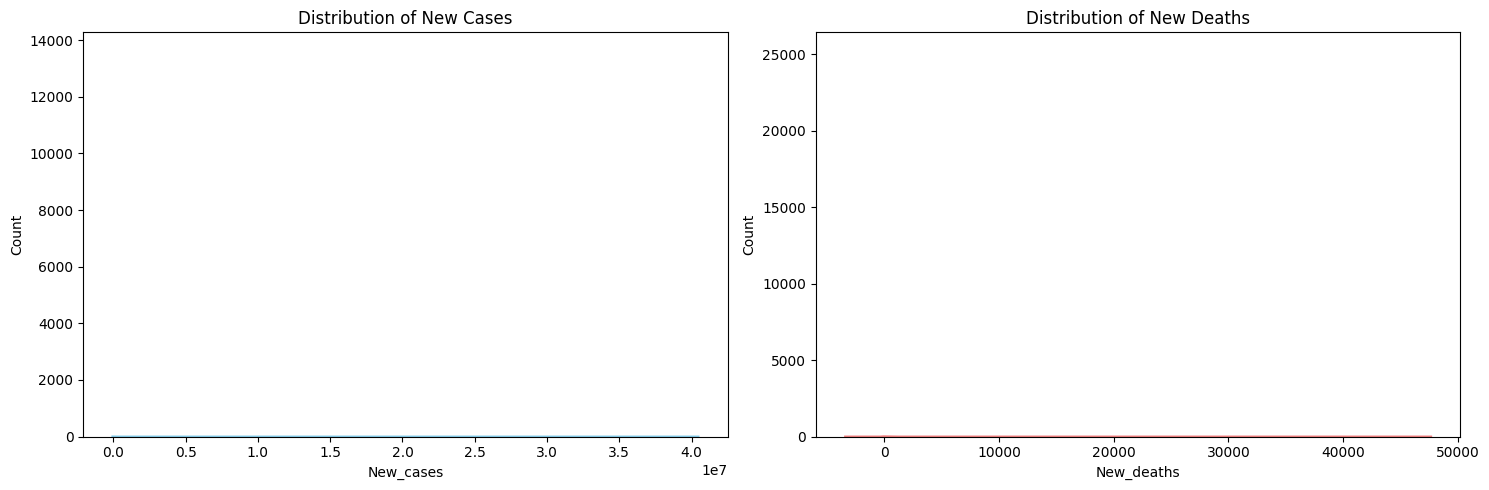

In [65]:
# Calculate the total number of cases and deaths by WHO region
total_cases_deaths_by_region = covid_data.groupby('WHO_region').agg({'New_cases': 'sum', 'New_deaths': 'sum'})

# Display the total number of cases and deaths by WHO region
total_cases_deaths_by_region


,New_cases,New_deaths
WHO_region,,
AFRO,10440440.0,279906.0
AMRO,193553999.0,3082311.0
EMRO,23779116.0,381211.0
EURO,279360814.0,2329030.0
OTHER,462302.0,20821.0
SEARO,61400252.0,825802.0
WPRO,209368825.0,508495.0


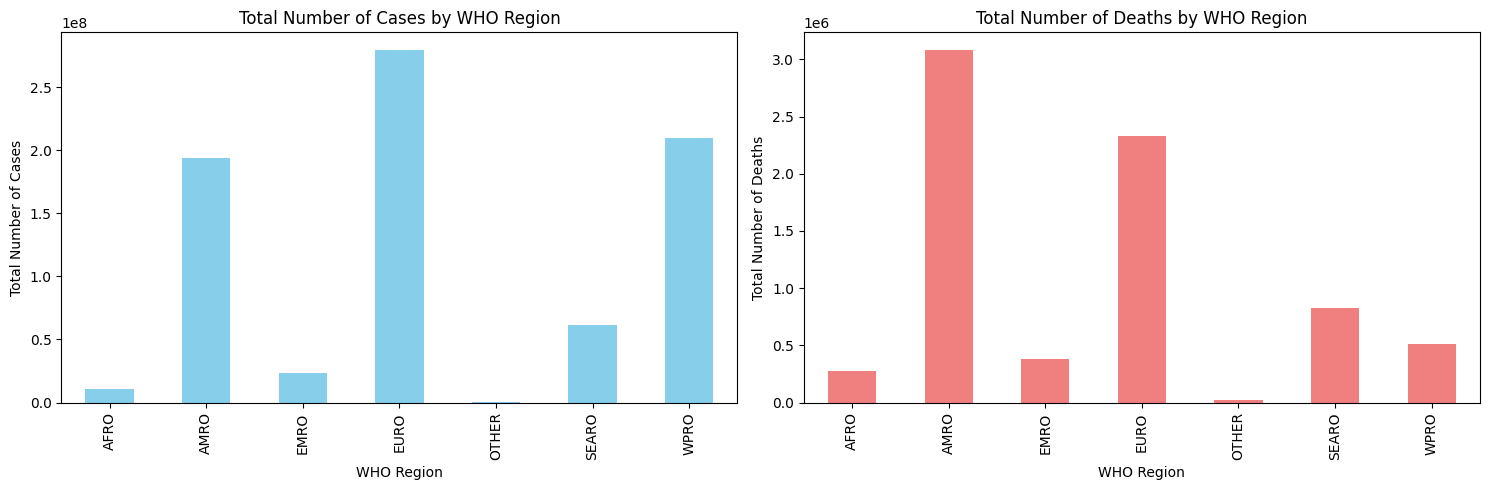

In [66]:
# Plot the total number of cases and deaths by WHO region
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
total_cases_deaths_by_region['New_cases'].plot(kind='bar', color='skyblue')
plt.title('Total Number of Cases by WHO Region')
plt.ylabel('Total Number of Cases')
plt.xlabel('WHO Region')

plt.subplot(1, 2, 2)
total_cases_deaths_by_region['New_deaths'].plot(kind='bar', color='lightcoral')
plt.title('Total Number of Deaths by WHO Region')
plt.ylabel('Total Number of Deaths')
plt.xlabel('WHO Region')

plt.tight_layout()
plt.show()


In [68]:
# Calculate the total number of cases and deaths by country
total_cases_deaths_by_country = covid_data.groupby('Country').agg({'New_cases': 'sum', 'New_deaths': 'sum'})

# Display the total number of cases and deaths by country
total_cases_deaths_by_country

,New_cases,New_deaths
Country,,
Afghanistan,231707.0,8220.0
Albania,346203.0,4880.0
Algeria,278058.0,8479.0
American Samoa,63925.0,3332.0
Andorra,65781.0,2607.0
...,...,...
Wallis and Futuna,72346.0,3459.0
Yemen,43319.0,3893.0
Zambia,361400.0,5361.0


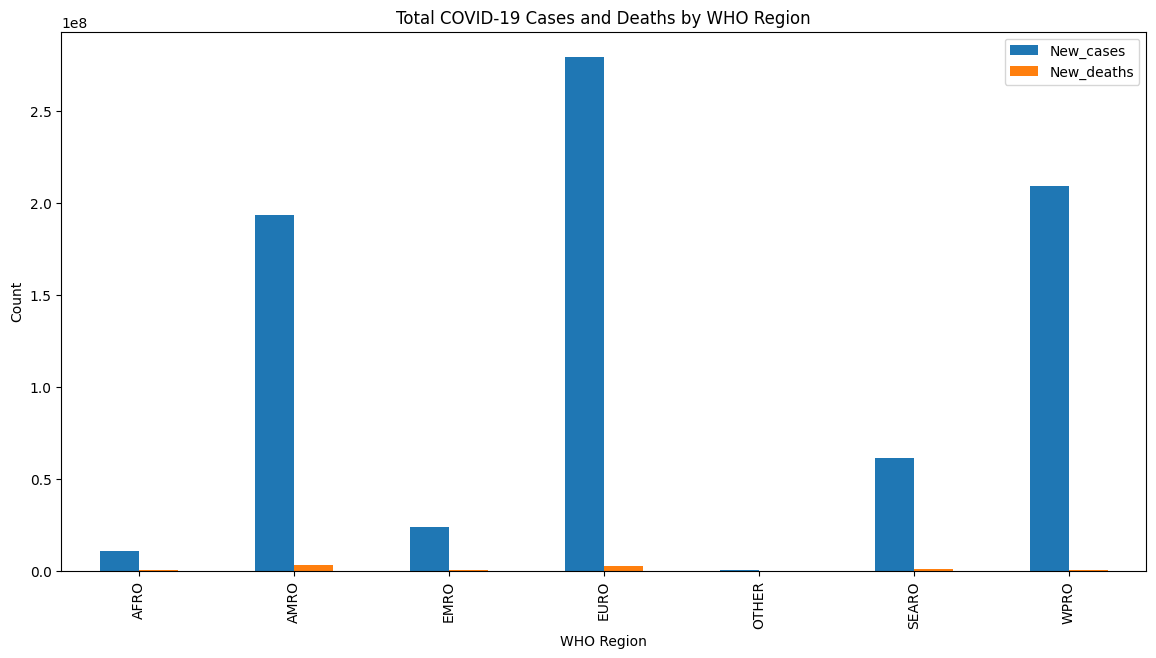

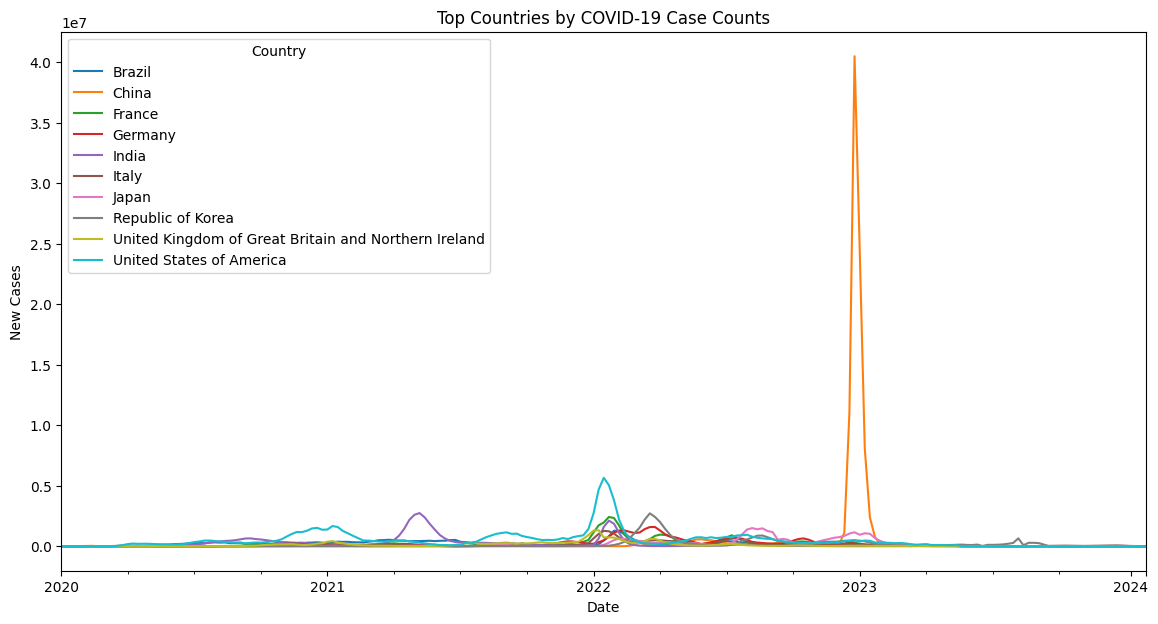

In [70]:
# Grouping data by WHO_region and plotting the total cases and deaths
covid_data.groupby('WHO_region')[['New_cases', 'New_deaths']].sum().plot(kind='bar', figsize=(14, 7), title='Total COVID-19 Cases and Deaths by WHO Region')
plt.xlabel('WHO Region')
plt.ylabel('Count')
plt.show()


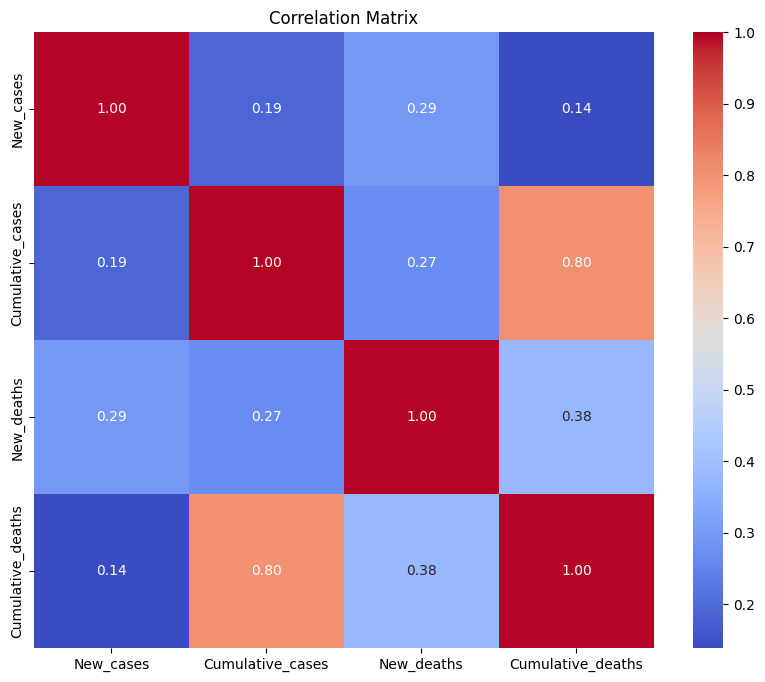

In [71]:
# Plotting a correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(covid_data[['New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


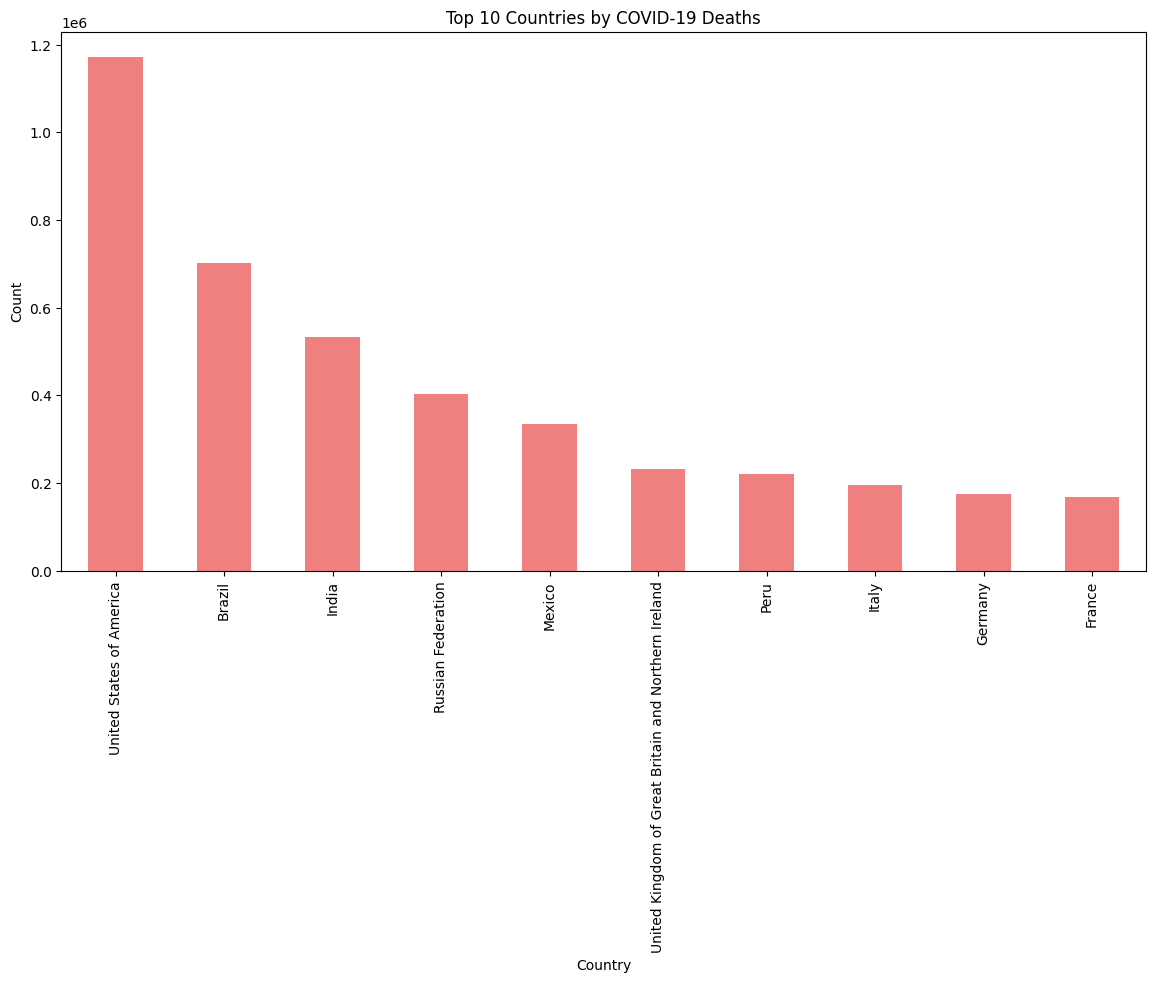

In [74]:
# plot the top 10 countries with the most deathsusing a bar plot
top_countries_deaths = covid_data.groupby('Country')['New_deaths'].sum().nlargest(10)
top_countries_deaths.plot(kind='bar', figsize=(14, 7), color='lightcoral', title='Top 10 Countries by COVID-19 Deaths')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()


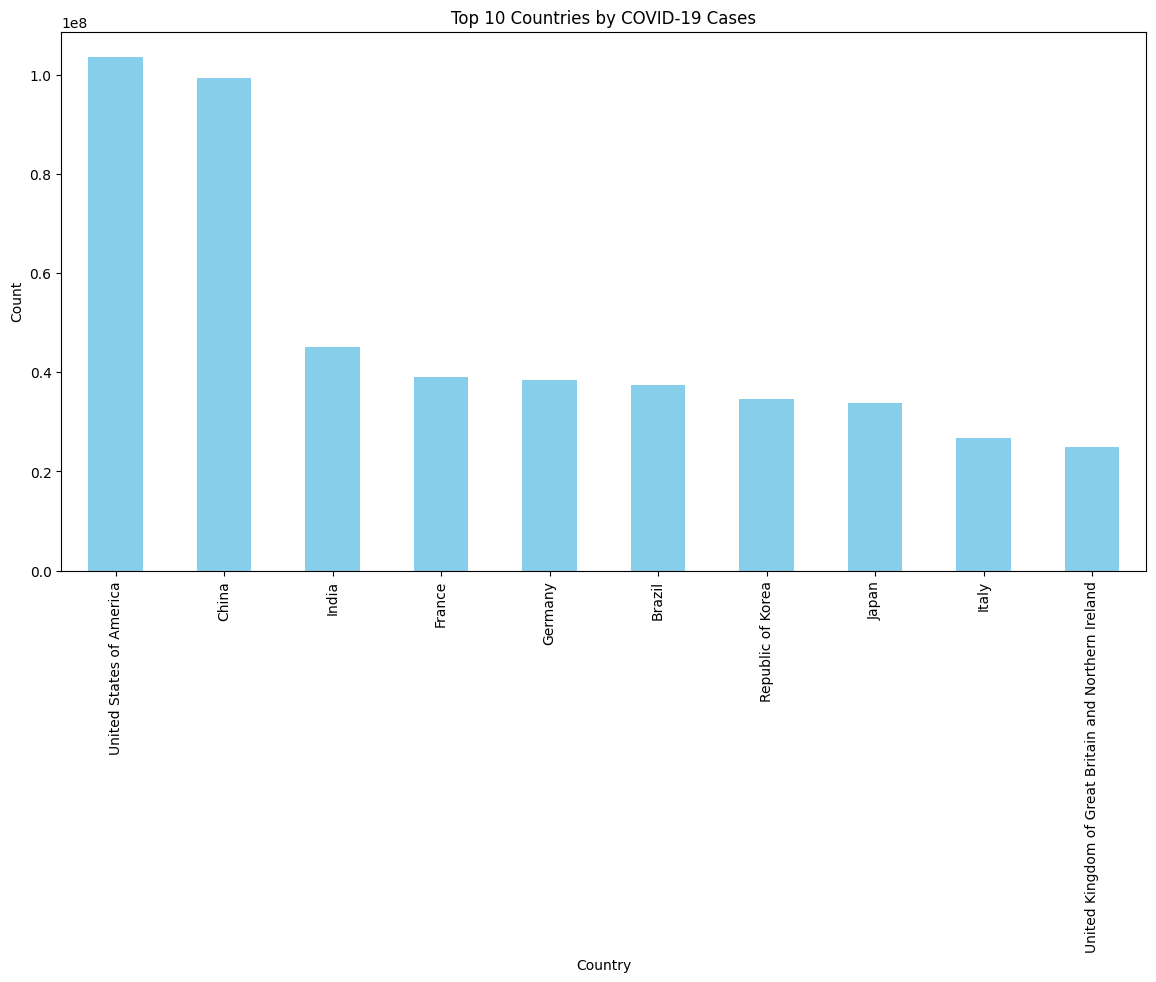

In [75]:
# plot the top 10 countries with the most cases using a bar plot with different colors
top_countries_cases = covid_data.groupby('Country')['New_cases'].sum().nlargest(10)
top_countries_cases.plot(kind='bar', figsize=(14, 7), color='skyblue', title='Top 10 Countries by COVID-19 Cases')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()


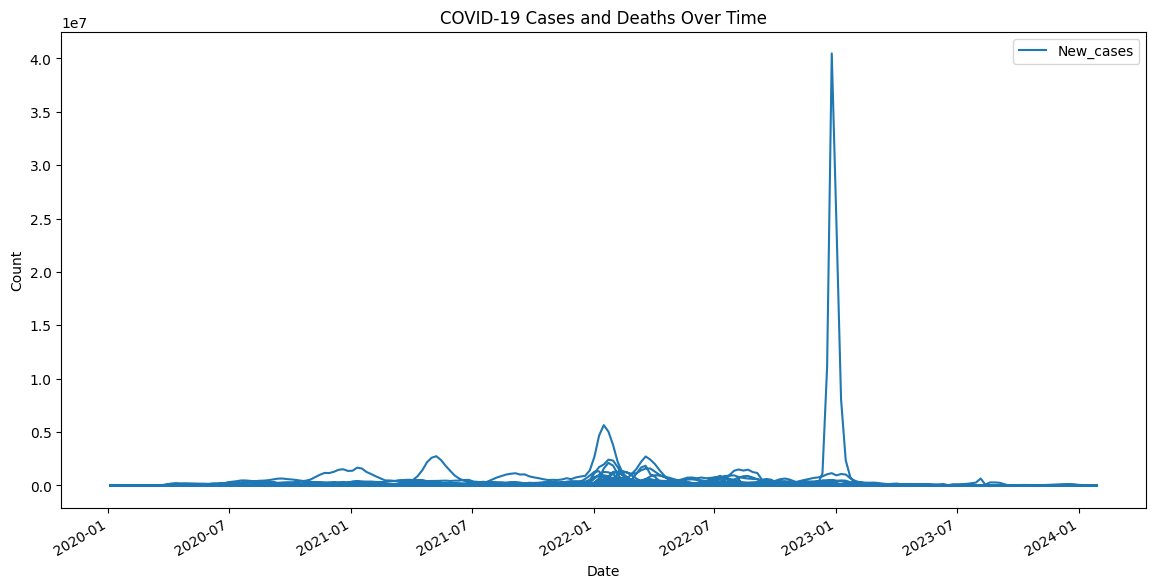

In [77]:
# Plotting the time series of new cases and deaths
covid_data.set_index('Date_reported')[['New_cases']].plot(figsize=(14, 7), title='COVID-19 Cases and Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


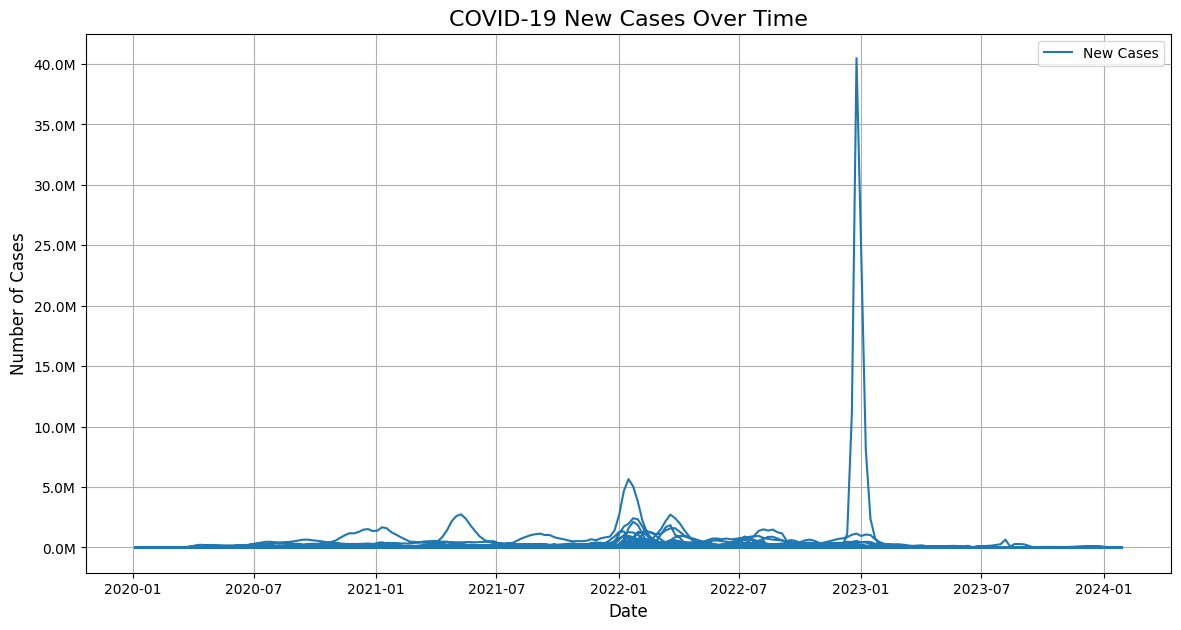

In [82]:
from matplotlib.ticker import FuncFormatter

# Set the 'Date_reported' as the index
covid_data.set_index('Date_reported', inplace=True)

def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

# Plot the time series of new cases
plt.figure(figsize=(14, 7))
plt.plot(covid_data['New_cases'], label='New Cases')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(formatter)

# Add titles and labels
plt.title('COVID-19 New Cases Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


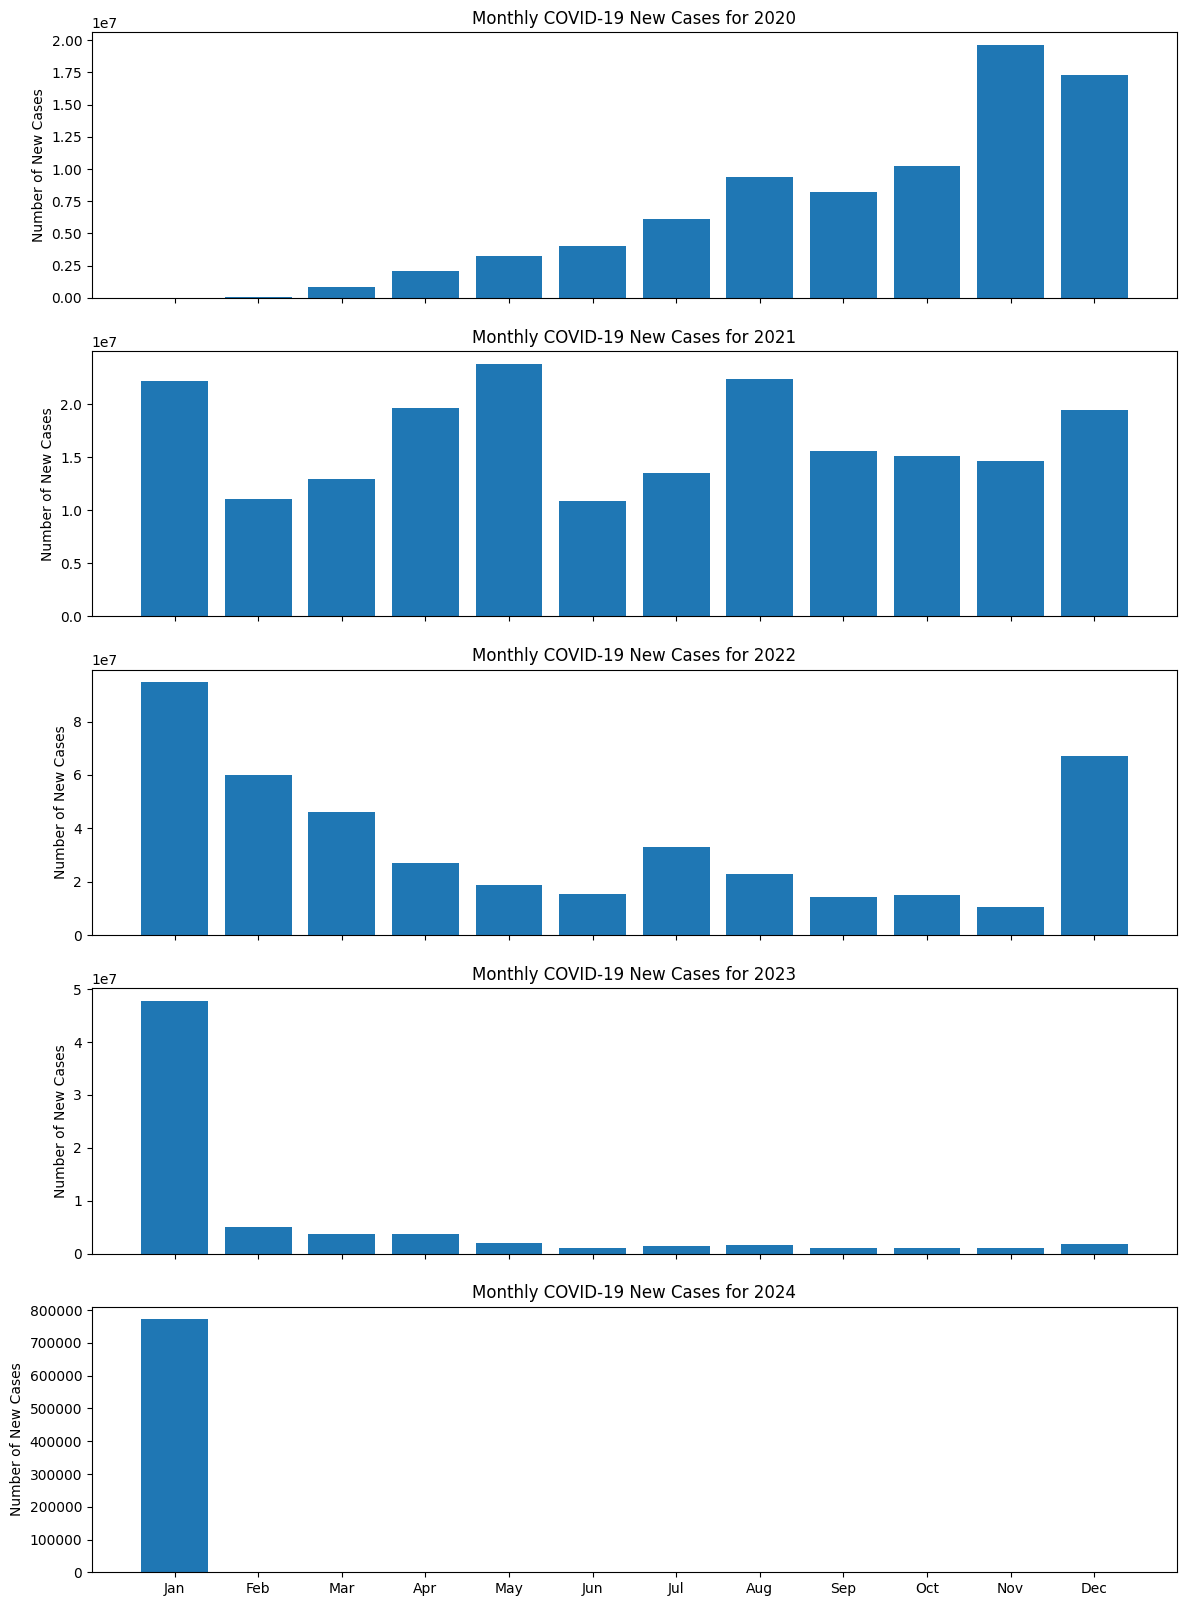

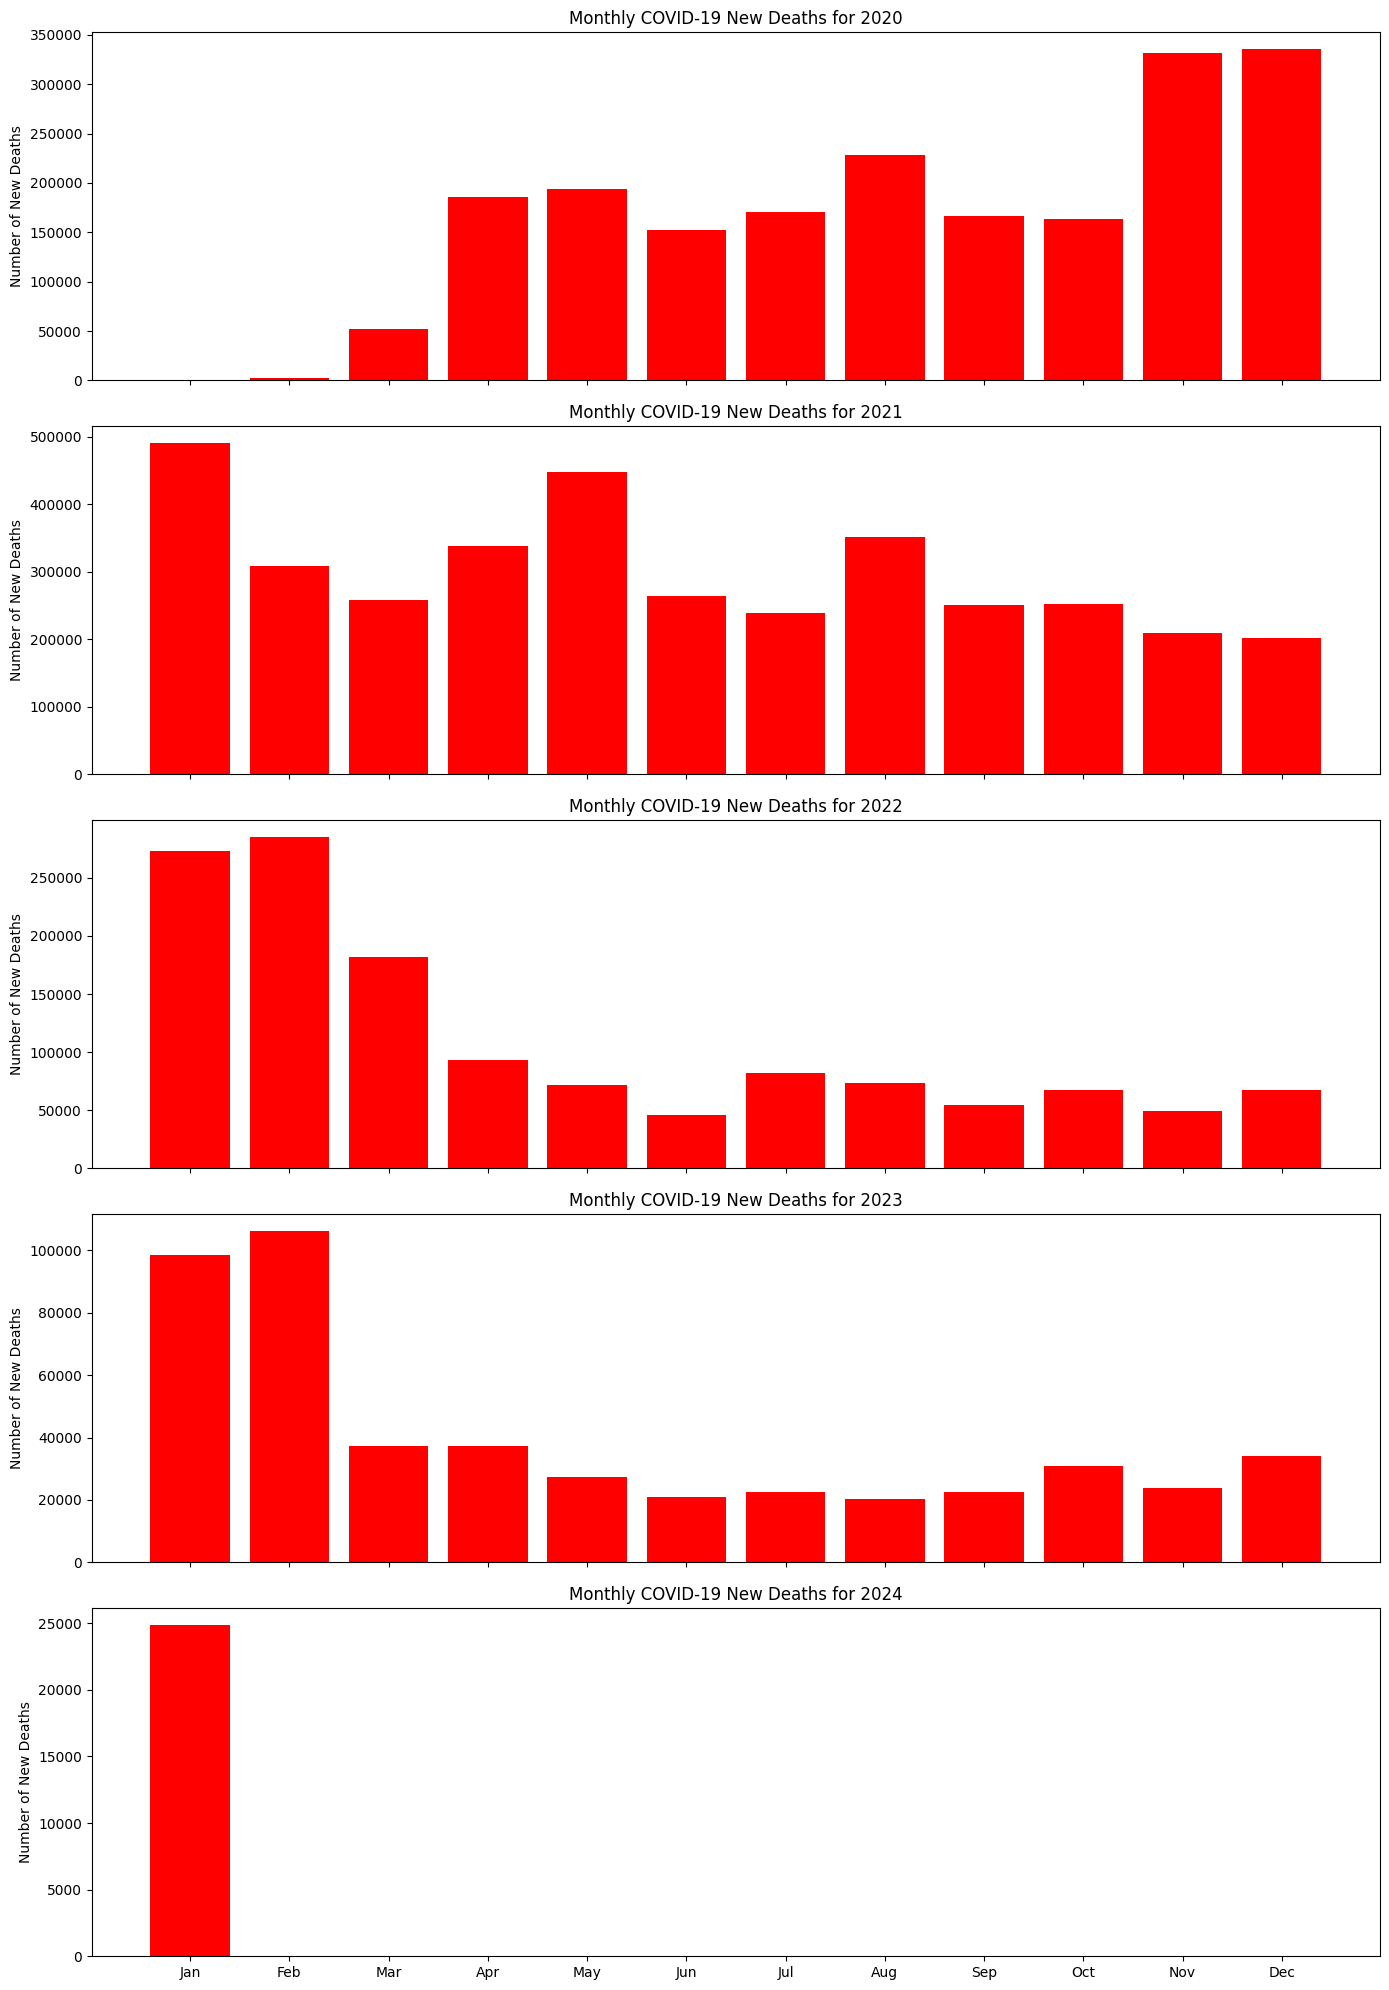

In [87]:
# Plotting the new cases for each year separately
fig_cases, axes_cases = plt.subplots(nrows=5, ncols=1, figsize=(14, 20), sharex=True)

# Generate bar plots for each year for new cases
for i, year in enumerate(range(2020, 2025)):
    monthly_cases = covid_data[covid_data.index.year == year]['New_cases'].resample('ME').sum() # Resample by month and sum
    axes_cases[i].bar(monthly_cases.index.month, monthly_cases.values)
    axes_cases[i].set_title(f'Monthly COVID-19 New Cases for {year}')
    axes_cases[i].set_xticks(range(1, 13))
    axes_cases[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes_cases[i].set_ylabel('Number of New Cases')

# Plotting the new deaths for each year separately
fig_deaths, axes_deaths = plt.subplots(nrows=5, ncols=1, figsize=(14, 20), sharex=True)

# Generate bar plots for each year for new deaths
for i, year in enumerate(range(2020, 2025)):
    monthly_deaths = covid_data[covid_data.index.year == year]['New_deaths'].resample('ME').sum() # Resample by month and sum
    axes_deaths[i].bar(monthly_deaths.index.month, monthly_deaths.values, color='red')
    axes_deaths[i].set_title(f'Monthly COVID-19 New Deaths for {year}')
    axes_deaths[i].set_xticks(range(1, 13))
    axes_deaths[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes_deaths[i].set_ylabel('Number of New Deaths')

plt.tight_layout()
plt.show()
